In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

import starry
import astropy.units as u
import jwst as jwst
import pickle as pkl

from numba import jit

from volcano.utils import *
from utils import *

np.random.seed(42)
starry.config.lazy = False

In [2]:
%matplotlib inline
%run notebook_setup.py

In [3]:
#  Stellar parameters
params_s = dict(
    r= 0.936* u.Rsun,  #  radius in R_sun
    m=0.96 * u.Msun,  # mass in M_sun
    prot=42.2 * u.d,  # rotational period in days
    u=[0.40, 0.25],  # limb darkening coefficients
    T=5165 * u.K,
    d=12.38 * u.pc,
)

# Planet parameters
params_p = dict(
    inc=83.3 * u.deg,  # inclination in degrees
    r=(1.91 * u.Rearth).to(u.Rsun),  #  radius in R_sun
    m=(8.08 * u.Mearth).to(u.Msun),  #  mass in M_sun
    porb=0.736539 * u.d,  # orbital period in days
    prot=0.736539 * u.d,  # rotational period in days
    t0=0.0,  # reference time in days (when it transits A)
    e=0.05,
    obl=0.
)

a = (params_p['porb'].to(u.yr).value**2)**(1/3.)*u.au
b = a.to(u.Rsun)/params_s['r'].to(u.Rsun)*np.cos(params_p['inc'].to(u.rad))
print("Impact angle: ", np.arcsin(b).to(u.deg))

Impact angle:  25.32921422510193 deg


## Create multi wavelength map, plot effective temperature

Monochromatic luminosity:
$$
L_\lambda=\pi(4\pi R^2)B_\lambda
$$ 

In [4]:
Nlam = 2000
lammin = 3.0
lammax = 7.0
lam = np.linspace(lammin, lammax, Nlam)

map_planet = starry.Map(ydeg=25, nw=Nlam)
map_planet.obl = params_p["obl"]
map_planet.inc = params_p["inc"]

# Set background temperature to 1000K
L = (
    np.pi * (4 * np.pi) * planck(1000, lam)
)  # Integrate Planck function over solid angle and area
map_planet.amp = (
    L / 4
)  #  Factor of 4 is here because in Starry the luminosity of a featureless map is 4.

background_int = map_planet.intensity()[0]

#  Sanity check
assert np.allclose(background_int, np.pi * planck(1000, lam))

def spot_sigma(ang_dim):
    spot_ang_dim = ang_dim * np.pi / 180
    return 1 - np.cos(spot_ang_dim / 2)

# Put one large spot on dayside to simulate insolation, set temperature of dayside spot to 1400K
dayside_int = np.pi * planck(2200, lam)

map_planet.add_spot(
    intensity=(dayside_int - background_int) / background_int / map_planet.amp,
    sigma=spot_sigma(80),
    lat=0.0,
    lon=180.0,
    relative=True,
)

# Place a high temperature spot on the dayside
spot_int = np.pi * planck(3200, lam)
spot_lat = 20.0
spot_lon = 180 + 40.0
spot_size = 50

I0 = map_planet.intensity(lat=spot_lat, lon=spot_lon)[0]

map_planet.add_spot(
    intensity=(spot_int - I0) / I0 / map_planet.amp,
    sigma=spot_sigma(spot_size),
    lat=spot_lat,
    lon=spot_lon,
    relative=True,
)

Pre-computing some matrices... Done.
Compiling `intensity`... Done.
Compiling `expand_spot`... Done.


In [5]:
# Plot temperature map of the planet
int_map = map_planet.render(res=300, theta=180)
teff_map = np.copy(int_map[0, :, :])

for i in range(int_map.shape[1]):
    for j in range(int_map.shape[2]):
        teff_map[i, j] = starry_intensity_to_teff(int_map[:, i, j], lam)

Compiling `render`... Done.


Pre-computing some matrices... Done.


Text(0.5, 1.0, 'Temperature map')

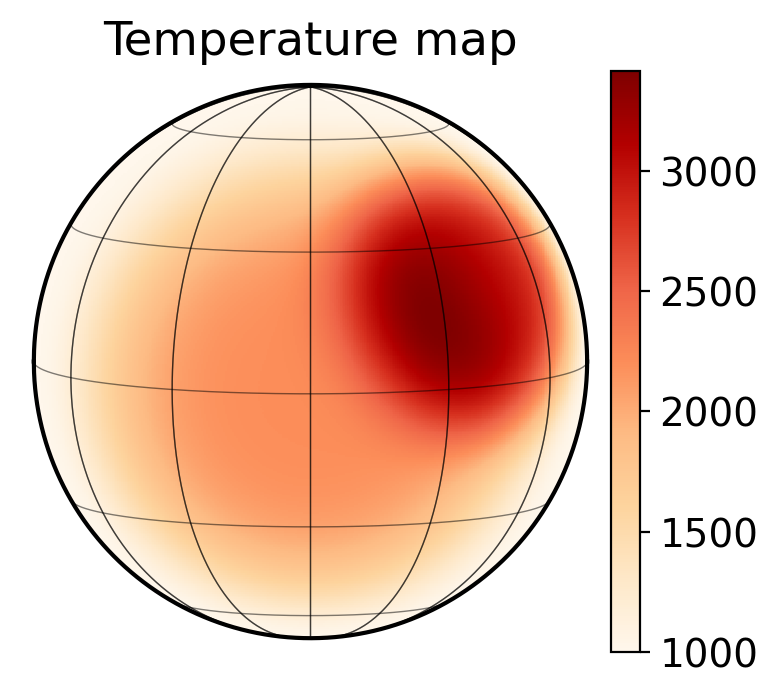

In [6]:
map = starry.Map(25)
map.obl = params_p["obl"]
map.inc = params_p["inc"]

fig, ax = plt.subplots(figsize=(4, 4))
map.show(
    image=teff_map, colorbar=True, ax=ax, cmap="OrRd"# norm=colors.Normalize(vmin=500, vmax=1300)
)
ax.set_title("Temperature map")

In [7]:
# Star map
map_star = starry.Map(ydeg=1, nw=Nlam)
Llam = (
    np.pi * (4 * np.pi) * planck(params_s['T'].value, lam)
)  # Integrate Planck function over solid angle and area
map_star.amp = (
    Llam / 4
)  #  Factor of 4 is here because in Starry the luminosity of a featureless map is 4.

# We need to scale the map ampltidues by R^2 to get fluxes in physical units
Rs = params_s["r"].to(u.m).value
Rp = params_p["r"].to(u.m).value
map_star.amp *= Rs ** 2
map_planet.amp *= Rp ** 2

Pre-computing some matrices... Done.


## Single band map

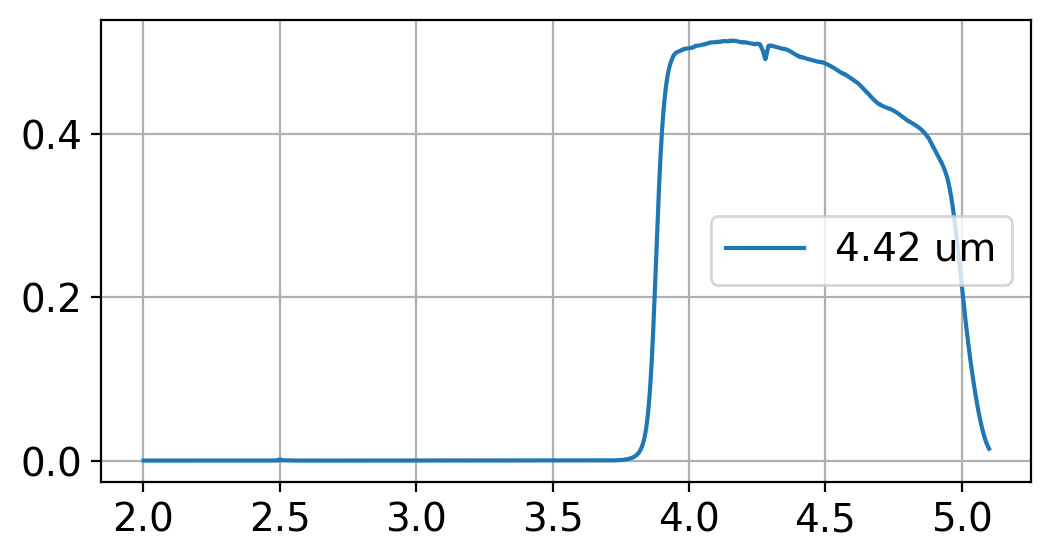

In [8]:
nircam_filters = jwst.get_nircam_filter_wheel()
miri_filters = jwst.get_miri_filter_wheel()

fig, ax = plt.subplots(figsize=(6, 3))
for fil in nircam_filters:
    ax.plot(fil.wl, fil.throughput, label=f"{fil.eff_wl:.2f} um")
    
ax.grid()
ax.legend(loc="right")
# ax.set_xlim(left=4.0)

In [9]:
# Transform the spectral maps to single band maps in the F444W NIRCAM filter
filt = nircam_filters[0]

# Interpolate filter throughout to HR grid
Thr = np.interp(lam, filt.wl, filt.throughput)

map_star_amp_filt = np.sum(map_star.amp * Thr) / np.sum(Thr, axis=0)
map_planet_amp_filt = np.sum(map_planet.amp * Thr) / np.sum(Thr, axis=0)

map_star_filt = starry.Map(map_star.ydeg)
map_star_filt.amp = np.sum(map_star.amp * Thr) / np.sum(Thr, axis=0)

map_planet_filt = starry.Map(map_planet.ydeg)
map_planet_filt.amp = np.sum(map_planet.amp * Thr) / np.sum(Thr, axis=0)
map_planet_filt[1:, :] = np.sum(map_planet[1:, :, :] * Thr, axis=1) / np.sum(Thr, axis=0)

map_planet_filt.obl = map_planet.obl
map_planet_filt.inc = map_planet.inc

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [10]:
print("Planet/star luminosity ratio", map_planet_filt.amp/map_star_filt.amp)

Planet/star luminosity ratio 3.0575656135965145e-05


Compiling `render`... Done.


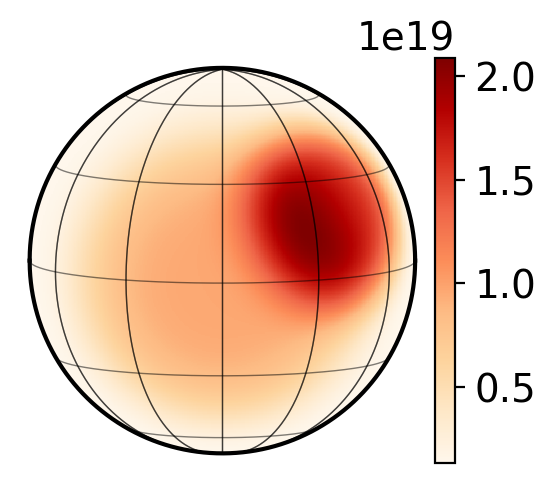

In [11]:
map_planet_filt.show(theta=180, cmap='OrRd', colorbar=True)

## Compute residuals with respect to uniform map

In [12]:
texp = 80*u.s

star = starry.Primary(
        map_star_filt,
        r=params_s["r"],
        m=params_s["m"],
        prot=params_s["prot"],
)

planet = starry.Secondary(
    map_planet_filt,
    r=params_p["r"],
    m=params_p["m"],
    porb=params_p["porb"],
    prot=params_p["prot"],
    t0=params_p["t0"],
    inc=params_p["inc"],
)
sys = starry.System(star, planet, texp=(texp.to(u.d)).value, oversample=9, order=0)

In [13]:
# Residuals between hotspot model and uniform model
t0 = -params_p['porb'] / 2
delta_t = 0.05*u.d

# Dense grid for visualization
t_ = np.linspace(t0.value - delta_t.value, t0.value + delta_t.value, 2000)

# Design matrix
A = sys.design_matrix(t_)

# For plotting
x_, y_, z_ = sys.position(t_)
x = x_[1, :] - x_[0, :]
y = y_[1, :] - y_[0, :]
z = z_[1, :] - z_[0, :]

pri_r = params_p['r'].value
sec_r = params_s['r'].value

xo = x / pri_r
yo = y / pri_r
zo = z / pri_r
ro = sec_r/pri_r

Compiling `X`... Done.
Compiling `position`... Done.


In [14]:
x_com = np.concatenate([
    map_star_filt.amp*map_star_filt._y,
    map_planet_filt.amp*map_planet_filt._y,
])

# Compute flux
flux = (A @ x_com[:, None]).flatten()

# Compute flux for uniform map
x_unif = np.copy(x_com)
x_unif[map_star_filt.Ny+1:] = np.zeros_like(map_planet_filt._y[1:])
amp_ = A[:, map_star_filt.Ny:] @ x_com[map_star_filt.Ny:][:, None]
x_unif[map_star_filt.Ny] = amp_[0]
flux_unif = (A @ x_unif[:, None]).flatten()

Text(0.5, 0.98, 'Residuals with respect to uniform map, filter F444W')

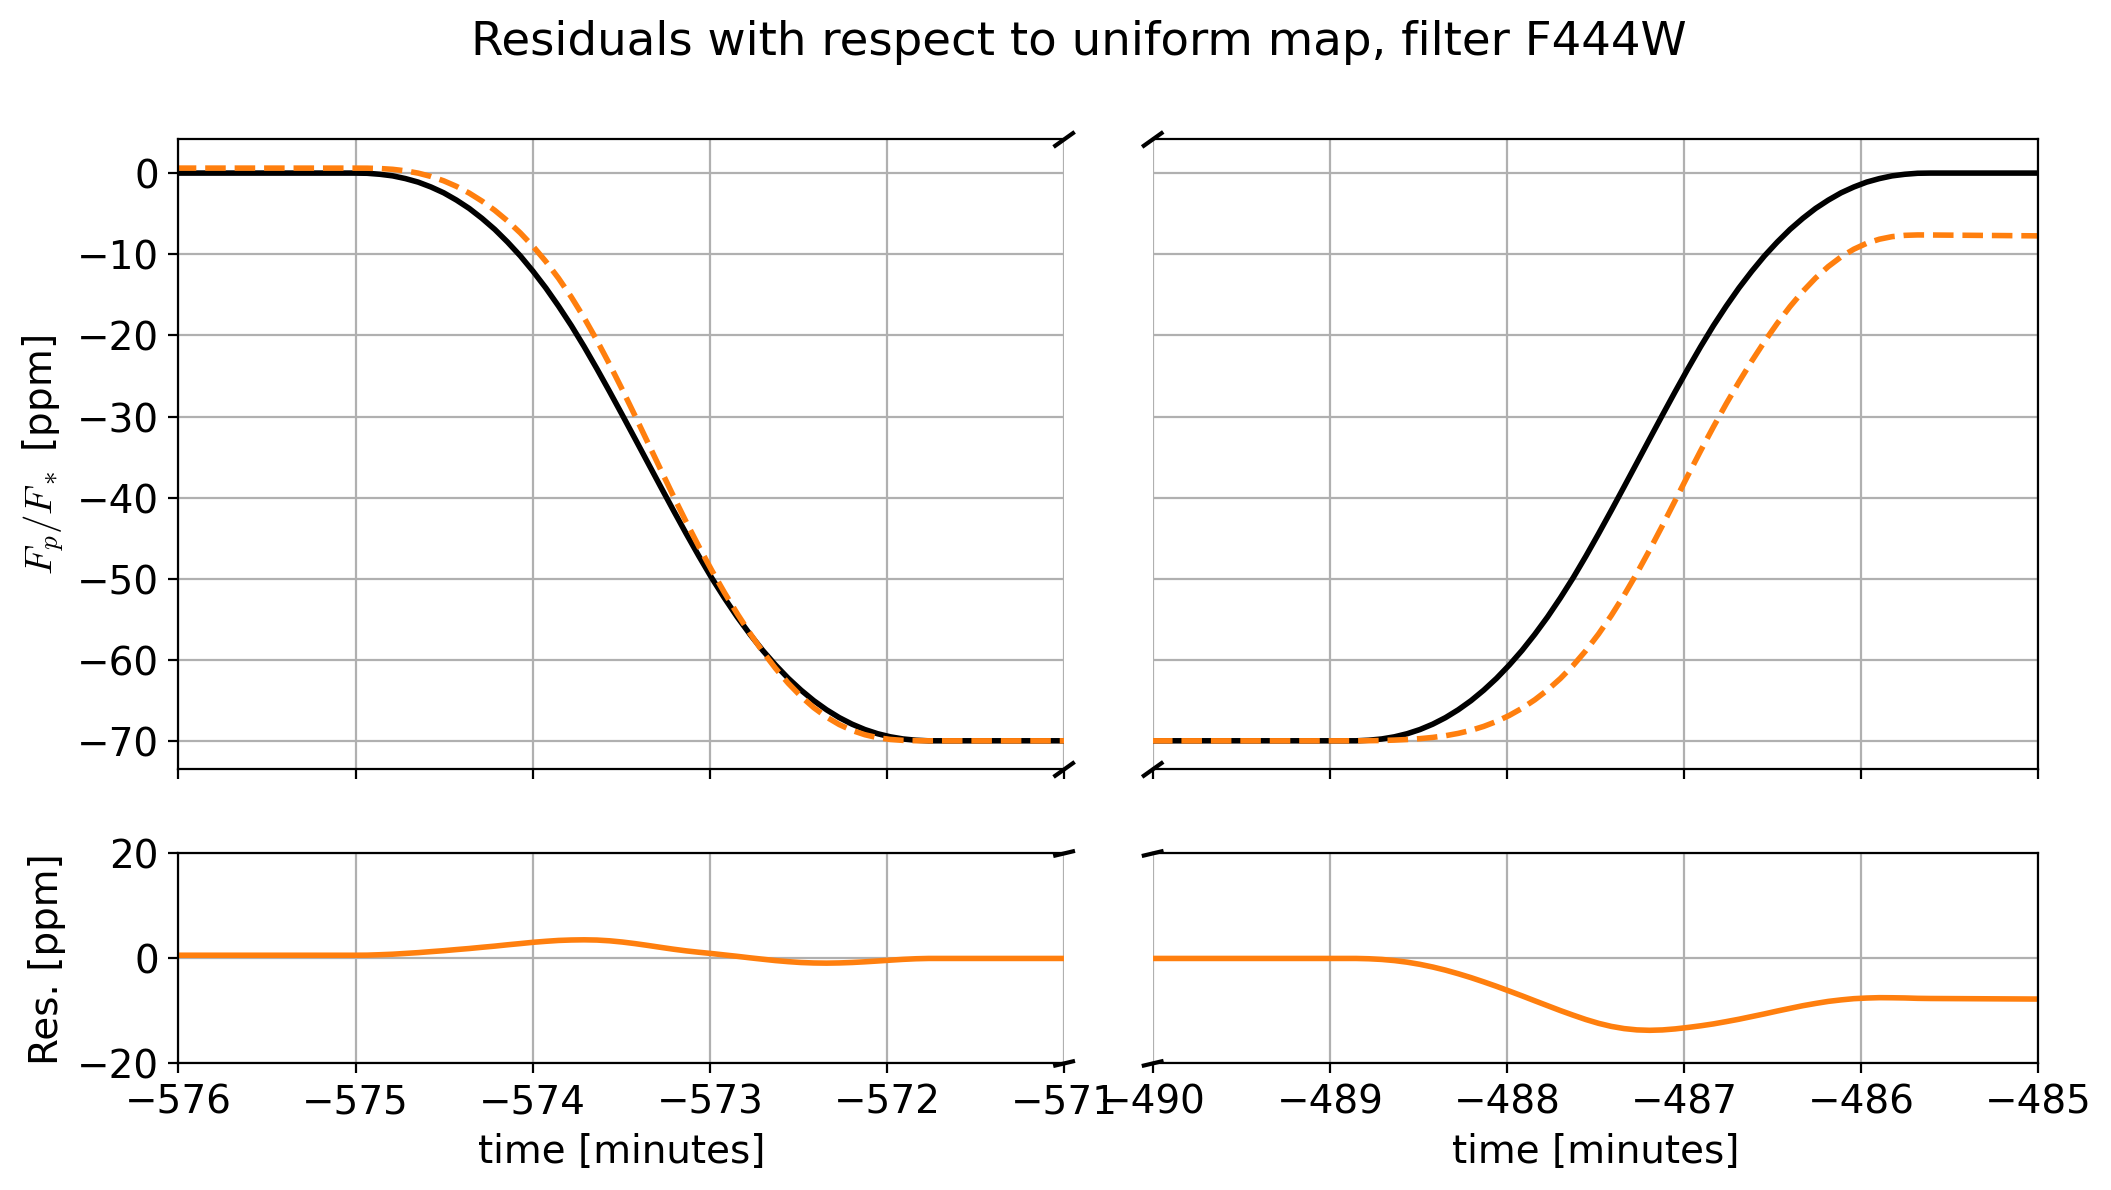

In [15]:
# Normalize and convert to parts-per-million scale
norm = np.max(flux_unif) 
flux_unif_norm = (flux_unif / norm - 1) * 1e06
flux_norm = (flux / norm - 1) * 1e06
res_unif = flux_norm - flux_unif_norm

fig, ax = plt.subplots(
    2, 2, figsize=(12, 6), gridspec_kw={"wspace": 0.1, "height_ratios": [3, 1]}
)

for a in ax[0, :]:
    a.plot(t_ * 24 * 60, flux_unif_norm , "k-", lw=2.0)
    a.plot(t_ * 24 * 60, flux_norm , "C1--", lw=2.0)

for a in ax[1, :]:
    a.plot(t_ * 24 * 60.0, res_unif, color="C1", lw=2.0)

# Make broken axis
for a in ax:
    a[0].spines["right"].set_visible(False)
    a[1].spines["left"].set_visible(False)
    a[1].tick_params(axis="y", colors=(0, 0, 0, 0))

    d = 0.01
    kwargs = dict(transform=a[0].transAxes, color="k", clip_on=False)
    a[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    a[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=a[1].transAxes)
    a[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)
    a[1].plot((-d, +d), (-d, +d), **kwargs)

for a in ax[0, :]:
    a.xaxis.set_ticklabels([])

for a in ax[:, 0]:
    a.set_xlim(-576, -576 + 5)

for a in ax[:, 1]:
    a.set_xlim(-490, -490 + 5)

for a in ax[1, :]:
    a.set_xlabel("time [minutes]")
    a.set_ylim(-20, 20)

for a in ax.flatten():
    a.grid()

ax[0, 0].set_ylabel(r"$F_p/F_*$ [ppm]")
ax[1, 0].set_ylabel("Res. [ppm]")

fig.suptitle("Residuals with respect to uniform map, filter F444W")

In [16]:
mask1 = np.logical_and(
    t_*24*60 > -575,
    t_*24*60 < -571,
)
mask2 = np.logical_and(
    t_*24*60 > -489,
    t_*24*60 < -485,
)

mask = np.logical_or(
    mask1, mask2
)

Pre-computing some matrices... Done.


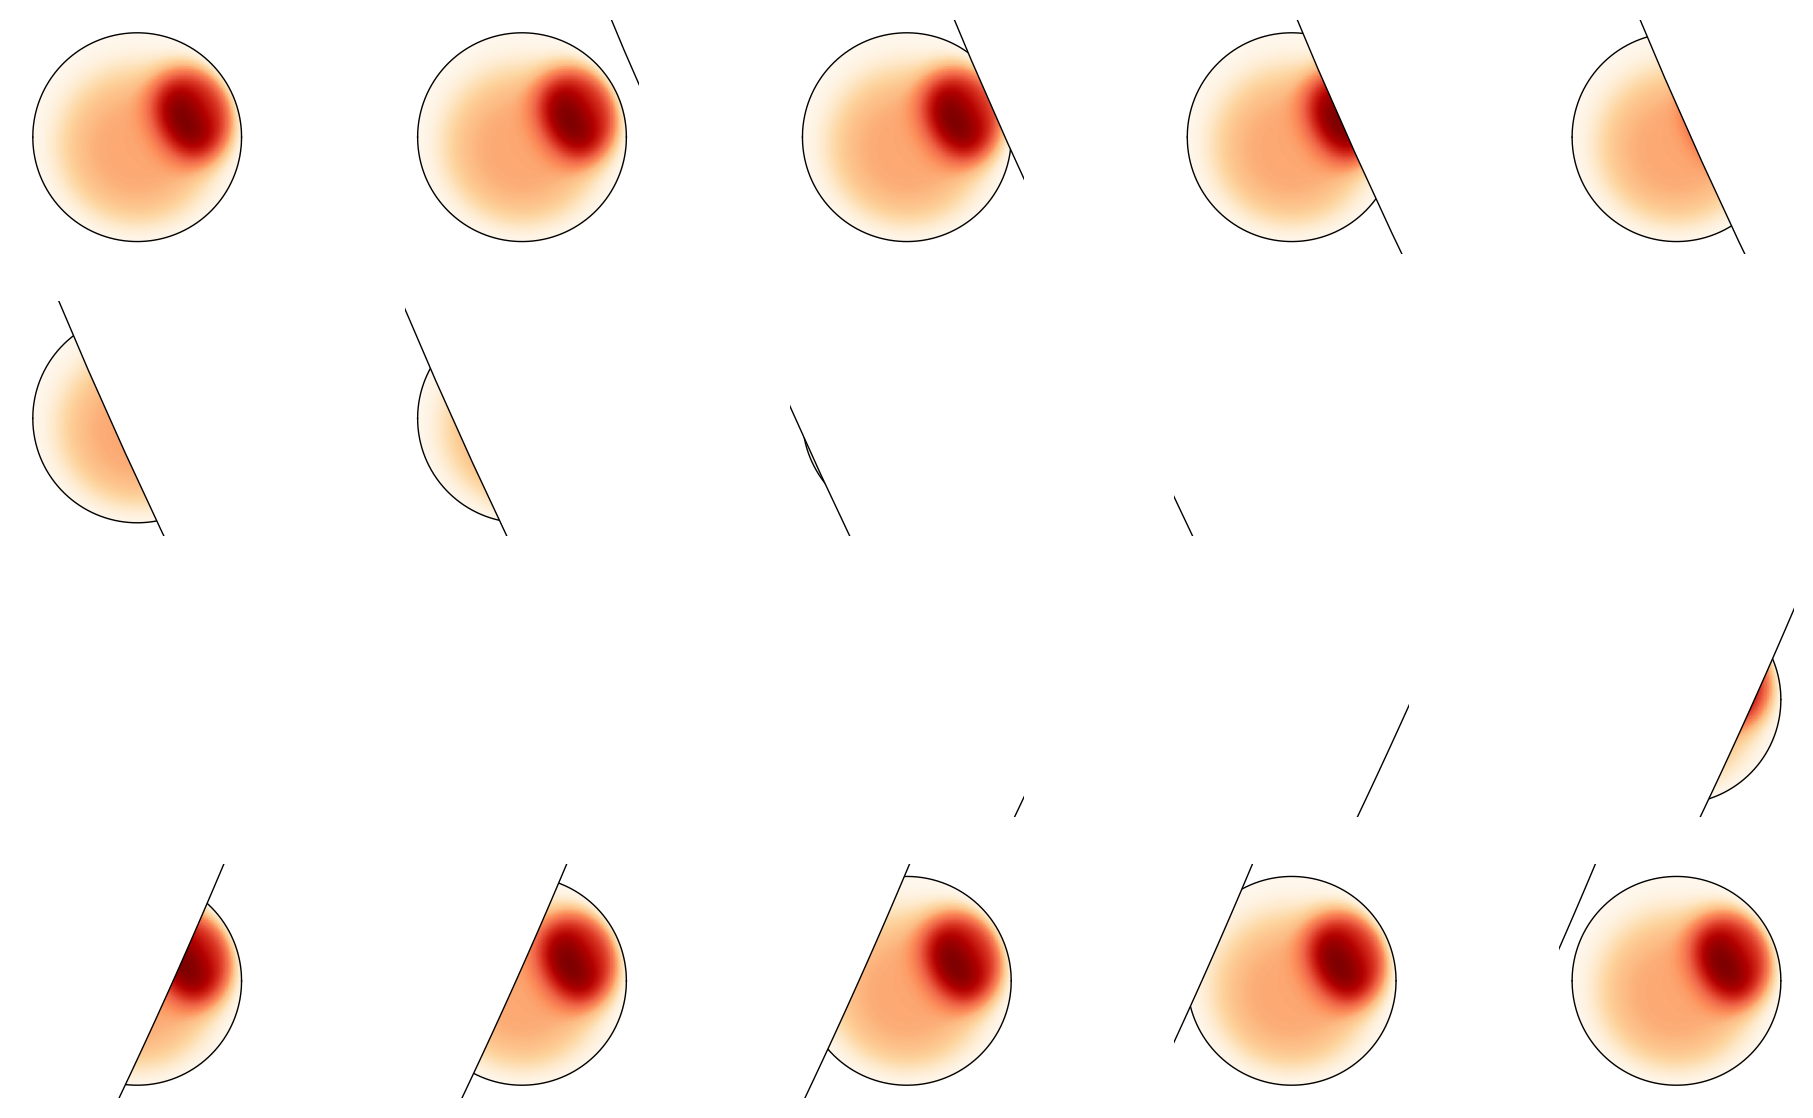

In [17]:
img = map_planet_filt.render(res=300, theta=180.)
map = starry.Map(20)

# Plot minimaps
resol = 300
xo_im = xo[mask][::5]
yo_im = yo[mask][::5]
nim = len(xo_im)

fig, ax = plt.subplots(4, 5, figsize=(12, 7))

for n, a in enumerate(fig.axes):
    if n < nim:
        # Show the image
        map.show(
            image=img,
            ax=a,
            grid=False,
            cmap="OrRd",
        )

        # Outline
        x = np.linspace(-1, 1, 1000)
        y = np.sqrt(1 - x ** 2)
        f = 0.98
        a.plot(f * x, f * y, "k-", lw=0.5, zorder=0)
        a.plot(f * x, -f * y, "k-", lw=0.5, zorder=0)

        # Occultor
        x = np.linspace(-1.5, xo_im[n] + ro - 1e-5, resol)
        y = np.sqrt(ro ** 2 - (x - xo_im[n]) ** 2)
        a.fill_between(
            x,
            yo_im[n] - y,
            yo_im[n] + y,
            fc="w",
            zorder=2,
            clip_on=True,
            ec="k",
            lw=0.5,
        )
        a.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
        a.set_rasterization_zorder(0)
    a.axis("off")

## Plot preimage

In [18]:
x_preimage, cho_cov = starry.linalg.solve(A, flux_norm, C=1e-02**2, L=1e5, N=A.shape[1])

Compiling `solve`... Done.


Pre-computing some matrices... Done.
Compiling `render`... Done.


Text(0.5, 0.98, 'Preimage')

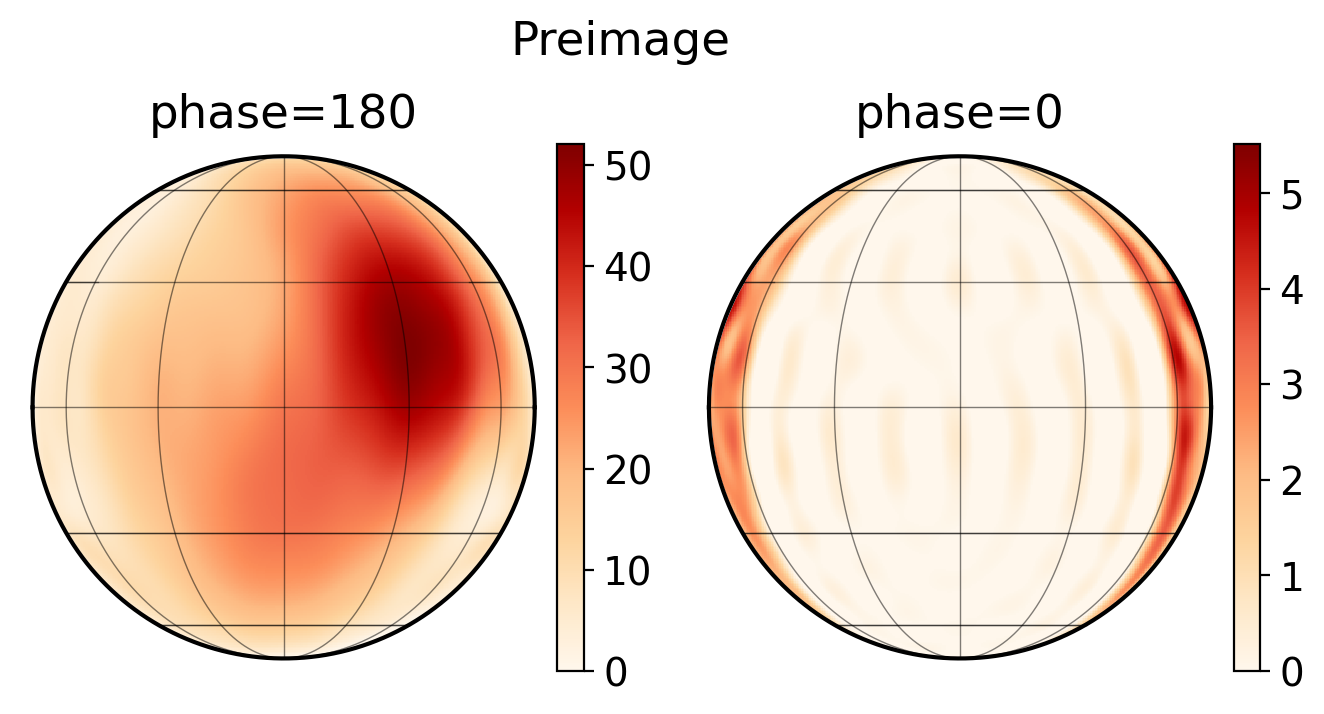

In [19]:
map = starry.Map(25)
map[1:, :] = x_preimage[map_star_filt.Ny + 1:]/x_preimage[map_star_filt.Ny]
map.amp = x_preimage[map_star_filt.Ny]

fig, ax = plt.subplots(1,2,figsize=(8, 4))
map.show(ax=ax[0], colorbar=True, theta=180, cmap="OrRd", norm=colors.Normalize(vmin=0))
map.show(ax=ax[1], colorbar=True, cmap="OrRd", norm=colors.Normalize(vmin=0))
ax[0].set_title('phase=180')
ax[1].set_title('phase=0')
fig.suptitle("Preimage")

# Generate simulated JWST light curve

In [20]:
nobs = 8  # Number of observations
npts = (
    int((2 * delta_t.to(u.s)) / texp.to(u.s)) * nobs
)  # total number of data points
t = np.linspace(t0.value - delta_t.value, t0.value + delta_t.value, npts)

In [21]:
star = starry.Primary(
    map_star,
    r=params_s["r"],
    m=params_s["m"],
    prot=params_s["prot"],
)

planet = starry.Secondary(
    map_planet,
    r=params_p["r"],
    m=params_p["m"],
    porb=params_p["porb"],
    prot=params_p["prot"],
    t0=params_p["t0"],
    inc=params_p["inc"],
)

# This is just to compute the continuum flux
planet_cont = starry.Secondary(
    map_planet,
    r=params_p["r"],
    m=params_p["m"],
    porb=params_p["porb"],
    prot=params_p["prot"],
    t0=params_p["t0"],
    inc=60.0,
)

sys_multiband = starry.System(star, planet, texp=(texp.to(u.d)).value, oversample=9, order=0)
sys_cont = starry.System(
    star, planet_cont, texp=(texp.to(u.d)).value, oversample=9, order=0
)  


# Compute spectrum in physical units
d = params_s["d"]
ftrue_lam = sys_multiband.flux(t=t) / (np.pi * (d.to(u.m)) ** 2)  #  W/m2/um
ftrue_cont = sys_cont.flux(t=t) / (np.pi * (d.to(u.m)) ** 2)  # W/m2/um

# Compute light curve using the function from planetplanet
filt.compute_lightcurve(
    t, ftrue_lam.value, ftrue_cont.value, lam, texp=(texp.to(u.d)).value
)
lc = filt.lightcurve

# Repeat for a uniform map
planet.map.amp = planet.map.flux(theta=180.0)
planet.map[1:, :, :] = np.zeros_like(planet.map[1:, :, :])
sys_unif = starry.System(star, planet, texp=(texp.to(u.d)).value, oversample=9, order=0)
ftrue_lam_unif = sys_unif.flux(t=t) / (np.pi * (d.to(u.m)) ** 2)  # W/m2/um
filt.compute_lightcurve(
    t, ftrue_lam_unif.value, ftrue_cont.value, lam, texp=(texp.to(u.d)).value
)
lc_unif = filt.lightcurve
ftrue_unif_ppm = (lc_unif.Nsys/np.max(lc_unif.Nsys) - 1)*1e06

Compiling `X`... Done.
Compiling `X`... Done.
Compiling `flux`... 

Computing observed light curve in F444W filter...


Done.
Compiling `X`... Done.


Computing observed light curve in F444W filter...


In [22]:
# Rescale light curve to ppm scale
obs = lc.norm*lc.obs/np.max(lc.Nsys)
sig = lc.norm*lc.sig/np.max(lc.Nsys)

fobs_ppm = (obs - 1.) * 1e06 
ferr_ppm = sig * 1e06

Text(0, 0.5, 'Res. [ppm]')

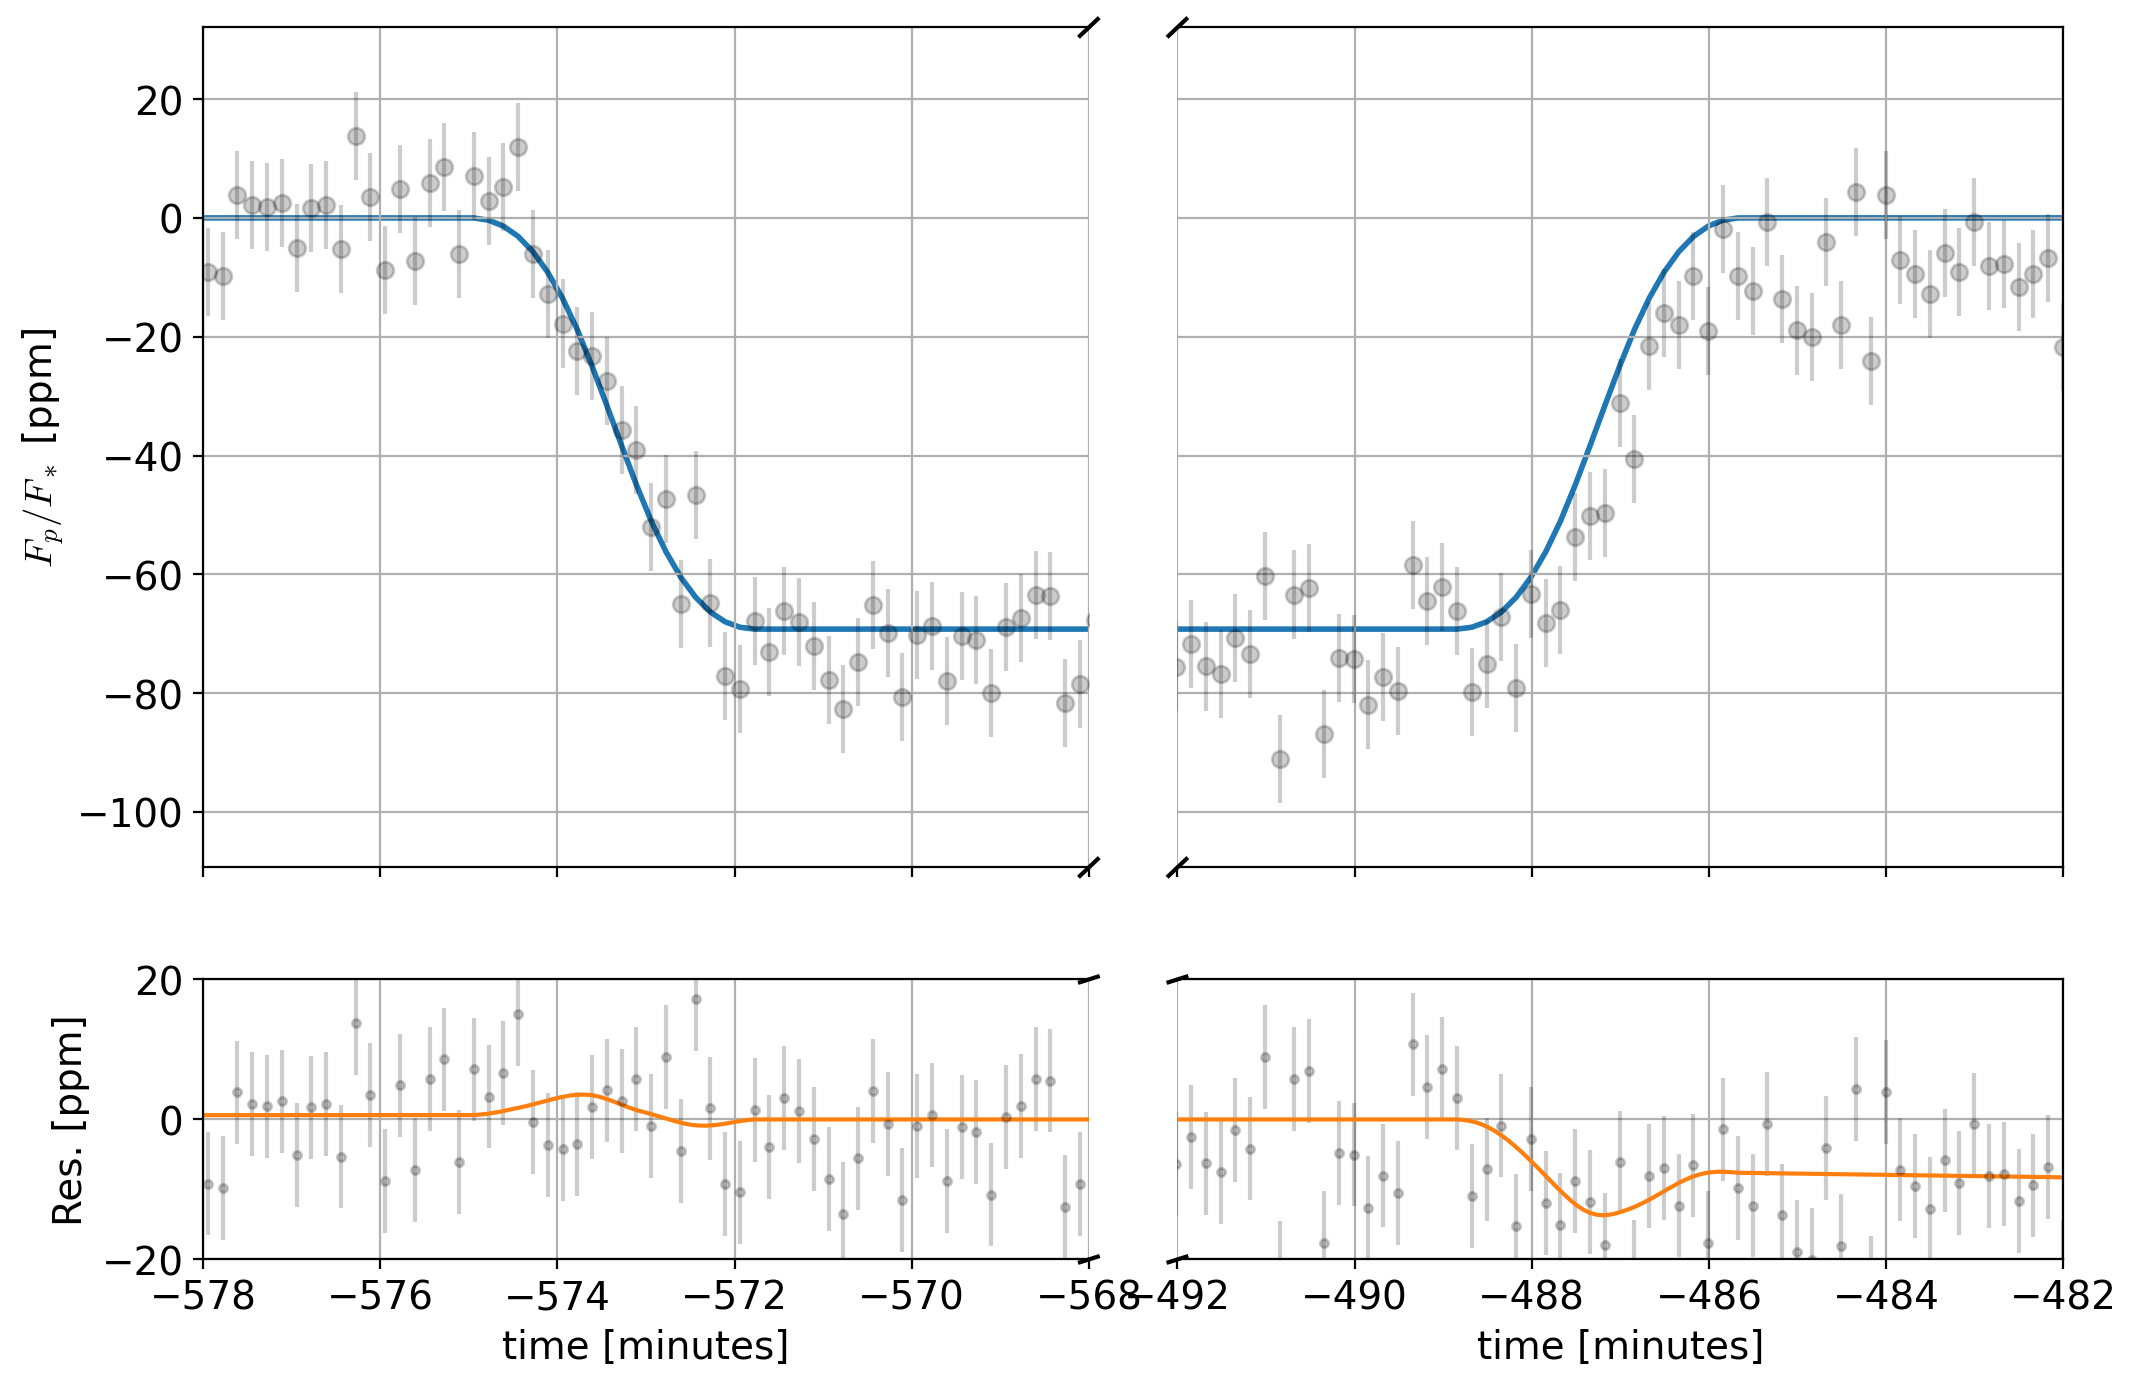

In [23]:
fig, ax = plt.subplots(
    2, 2, figsize=(12, 8), gridspec_kw={"wspace": 0.1, "height_ratios": [3, 1]}
)

# Plot uniform model
for a in ax[0, :]:
    a.plot(t * 24 * 60, ftrue_unif_ppm, "C0-", lw=2.0, zorder=-1)
    
# Plot data
for a in ax[0, :]:
    a.errorbar(
        lc.time * 24 * 60,
        fobs_ppm,
        ferr_ppm,
        marker="o",
        linestyle="",
        color="black",
        alpha=0.2,
    )


# Plot residuals
res = fobs_ppm - ftrue_unif_ppm

for a in ax[1, :]:
    a.errorbar(
        lc.time * 24 * 60,
        res ,
        ferr_ppm,
        marker=".",
        linestyle="",
        color="black",
        alpha=0.2,
    )
    a.plot(t_*24*60, res_unif, 'C1-')

# Make broken axis
for a in ax:
    a[0].spines["right"].set_visible(False)
    a[1].spines["left"].set_visible(False)
    a[1].tick_params(axis="y", colors=(0, 0, 0, 0))

    d = 0.01
    kwargs = dict(transform=a[0].transAxes, color="k", clip_on=False)
    a[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    a[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=a[1].transAxes)
    a[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)
    a[1].plot((-d, +d), (-d, +d), **kwargs)

for a in ax[0, :]:
    a.xaxis.set_ticklabels([])

for a in ax[:, 0]:
    a.set_xlim(-578, -578 + 10)

for a in ax[:, 1]:
    a.set_xlim(-492, -492 + 10)
for a in ax[1, :]:
    a.set_ylim(-20, 20)

for a in ax[1, :]:
    a.set_xlabel("time [minutes]")
#     a.set_yticks([-10, 0, 10])

for a in ax.flatten():
    a.grid()

ax[0, 0].set_ylabel(r"$F_p/F_*$ [ppm]")
ax[1, 0].set_ylabel("Res. [ppm]")

In [24]:
metadata = {"texp": texp}

#  Save to file
with open("warm_jupiter_lc.pkl", "wb") as handle:
    pkl.dump(lc, handle)
with open("warm_jupiter_star_params.pkl", "wb") as handle:
    pkl.dump(params_s, handle)
with open("warm_jupiter_planet_params.pkl", "wb") as handle:
    pkl.dump(params_p, handle)
with open("warm_jupiter_metadata.pkl", "wb") as handle:
    pkl.dump(metadata, handle)